<a href="https://colab.research.google.com/github/sisomimoctrl/study-tensorflow/blob/main/boston_housing_k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print(tf.__version__)

2.8.2


In [2]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
import pandas as pd
import numpy as np

columns_name = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
                'PTRATIO', 'B', 'LSTAT', 'MEDV']
"""
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
"""

df = pd.DataFrame(np.concatenate((train_data, train_targets.reshape(-1, 1)), axis=1), columns=columns_name)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20,19.4
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59,25.2
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83,19.4
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79,19.4


In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
import numpy as np

k = 2
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(
        partial_train_data, 
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1


In [7]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

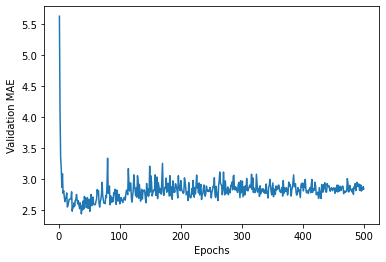

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

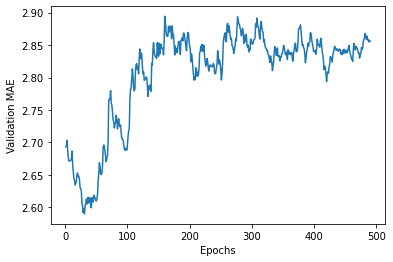

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [10]:
average_mae_history

[5.629656076431274,
 4.093448877334595,
 3.353075861930847,
 3.1806081533432007,
 2.8660690784454346,
 3.0858973264694214,
 2.7712347507476807,
 2.813603401184082,
 2.7123472690582275,
 2.6381531953811646,
 2.6932456493377686,
 2.710190176963806,
 2.777866840362549,
 2.5505398511886597,
 2.5740103721618652,
 2.6207107305526733,
 2.675453305244446,
 2.674407482147217,
 2.6784602403640747,
 2.694900155067444,
 2.795533776283264,
 2.482635021209717,
 2.5657185316085815,
 2.5395829677581787,
 2.61872136592865,
 2.5655046701431274,
 2.659722089767456,
 2.665439009666443,
 2.752855896949768,
 2.6687783002853394,
 2.600270628929138,
 2.651202440261841,
 2.591926097869873,
 2.5220953226089478,
 2.6182674169540405,
 2.5825116634368896,
 2.438765287399292,
 2.562984347343445,
 2.505648136138916,
 2.648916482925415,
 2.5187398195266724,
 2.7211623191833496,
 2.6070553064346313,
 2.6965681314468384,
 2.541116952896118,
 2.610289692878723,
 2.7020316123962402,
 2.5284643173217773,
 2.61956954002380

In [11]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 15.8758 - mae: 2.4727


In [12]:
print(test_mae_score)

2.4727375507354736
